In [11]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pandas as pd

     pcost       dcost       gap    pres   dres
 0:  1.5094e+04 -2.1028e+05  3e+05  8e-02  6e-14
 1:  4.8365e+03 -2.4550e+04  3e+04  6e-03  8e-14
 2:  2.3820e+02 -5.0039e+03  5e+03  6e-04  8e-14
 3: -5.9821e+02 -2.0467e+03  1e+03  1e-04  7e-14
 4: -8.6095e+02 -1.8067e+03  9e+02  6e-05  7e-14
 5: -1.0436e+03 -1.3231e+03  3e+02  1e-05  6e-14
 6: -1.0872e+03 -1.2571e+03  2e+02  6e-06  7e-14
 7: -1.1429e+03 -1.1786e+03  4e+01  3e-13  9e-14
 8: -1.1539e+03 -1.1616e+03  8e+00  1e-13  8e-14
 9: -1.1568e+03 -1.1570e+03  2e-01  1e-13  8e-14
10: -1.1569e+03 -1.1569e+03  2e-02  5e-15  1e-13
11: -1.1569e+03 -1.1569e+03  2e-04  2e-13  9e-14
Optimal solution found.
21 support vectors out of 100 points
96 out of 100 predictions correct


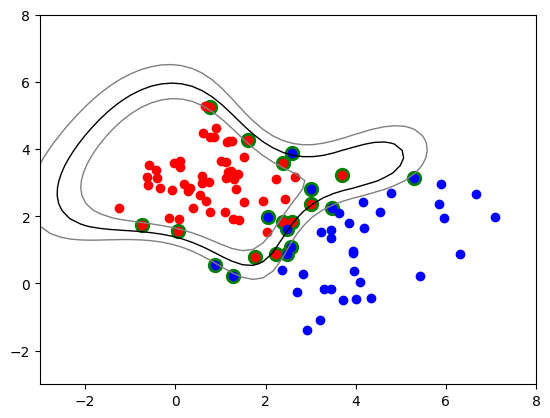

In [12]:
def gaussian_kernel(x, y, sigma=1.75):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=gaussian_kernel, C=100.0):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        n_samples= X.shape[0]

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        G = cvxopt.matrix(np.vstack((np.eye(n_samples)*-1,np.eye(n_samples))))
        h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        A = cvxopt.matrix(y.reshape(1,-1)*1.0)
        b = cvxopt.matrix(0.0)


        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        lambdas = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = lambdas > 0.09999
        ind = np.arange(len(lambdas))[sv]
        self.lambdas = lambdas[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]

        print("%d support vectors out of %d points" % (len(self.lambdas), n_samples))

        # Offset
        self.b = 0
        for n in range(len(self.lambdas)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.lambdas * self.sv_y * K[ind[n],sv])
        self.b /= len(self.lambdas)
        
        # Weight vector
        self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for lambdas, sv_y, sv in zip(self.lambdas, self.sv_y, self.sv):
                    s += lambdas * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

if __name__ == "__main__":
    import pylab as pl

    def gen_non_lin_separable_data():
        df=pd.read_excel('proj2dataset.xlsx',header=None)
        df=df.set_axis(['x1', 'x2', 'class'], axis='columns')
        c1=df.where(df['class']==1).dropna()[['x1','x2']].values
        c2=df.where(df['class']==-1).dropna()[['x1','x2']].values
        X=df[['x1','x2']].values
        y=df[['class']].values
        return c1, y[:len(c1)], c2, y[len(c1):]

    def split_train(X1, y1, X2, y2):
        X_train = np.vstack((X1, X2))
        y_train = np.hstack((y1.flatten(), y2.flatten()))
        return X_train, y_train

    def split_test(X1, y1, X2, y2):
        X_test = np.vstack((X1, X2))
        y_test = np.hstack((y1.flatten(), y2.flatten()))
        return X_test, y_test

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(-3,8,50), np.linspace(-3,8,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

    def test_non_linear():
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(gaussian_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
        

    test_non_linear()
    
